In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 2.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np

# Nazwy plików
FILE_PATH = 'data_after_filter.csv'
MODEL_FILE_NAME = 'model_catboost.pkl'
RESULTS_FILE_NAME = 'raport_catboost.txt'

# --- 1. Wczytanie Danych ---
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"BŁĄD: Nie znaleziono pliku: {FILE_PATH}")
    exit()

# --- 2. Czyszczenie Danych ---
# Usuwamy duplikaty kolumn
df = df.loc[:, ~df.columns.duplicated()]

# --- 3. Przygotowanie Danych ---
X = df.drop(['Resume_ID', 'Recruiter Decision'], axis=1, errors='ignore')
y = df['Recruiter Decision']

# --- 4. Podział na Zbiór Treningowy i Testowy ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# --- 5. Trenowanie Modelu (CatBoost) ---
print("Rozpoczynam trening CatBoost...")

model = CatBoostClassifier(
    iterations=1500,         # Liczba drzew
    learning_rate=0.03,      # Szybkość uczenia
    depth=8,                # Głębokość drzewa
    loss_function='Logloss',
    auto_class_weights='Balanced', # Automatyczne balansowanie klas!
    verbose=0,              # 0 = cisza (nie wypisuj logów treningu)
    random_state=42
)

model.fit(X_train, y_train)
print("--- 5. Model CatBoost został wytrenowany ---")

# --- 6. Ocena Modelu ---
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Odrzucony (0)', 'Zaproszony (1)'])

print(f"Dokładność: {accuracy:.4f}")
print("Raport klasyfikacji:\n", report)

# --- 7. Ważność Cech ---
importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame(
    {'Cecha': X.columns, 'Ważność': importances}
).sort_values(by='Ważność', ascending=False)

print("\nTop 10 najważniejszych cech wg CatBoost:")
print(feature_importance_df.head(10))

# --- 8. Zapis wyników ---
with open(RESULTS_FILE_NAME, 'w', encoding='utf-8') as f:
    f.write(f"Model: CatBoost\n")
    f.write(f"Dokładność: {accuracy:.4f}\n\n")
    f.write("Raport:\n")
    f.write(report)
    f.write("\n\nWażność cech:\n")
    f.write(feature_importance_df.head(10).to_string())

joblib.dump(model, MODEL_FILE_NAME)
print(f"\nZapisano model do {MODEL_FILE_NAME}")

Rozpoczynam trening CatBoost...
--- 5. Model CatBoost został wytrenowany ---
Dokładność: 0.9533
Raport klasyfikacji:
                 precision    recall  f1-score   support

 Odrzucony (0)       0.98      0.96      0.97       244
Zaproszony (1)       0.84      0.93      0.88        56

      accuracy                           0.95       300
     macro avg       0.91      0.94      0.93       300
  weighted avg       0.96      0.95      0.95       300


Top 10 najważniejszych cech wg CatBoost:
                     Cecha    Ważność
0       Experience (Years)  46.551214
5           Projects Count  25.622149
4   Salary Expectation ($)   4.820478
1                Education   4.744888
2           Certifications   4.590926
3                 Job Role   1.280363
18                     SQL   1.204537
29                  Python   1.188377
11                   Linux   1.017467
15                  Python   0.933927

Zapisano model do model_catboost.pkl


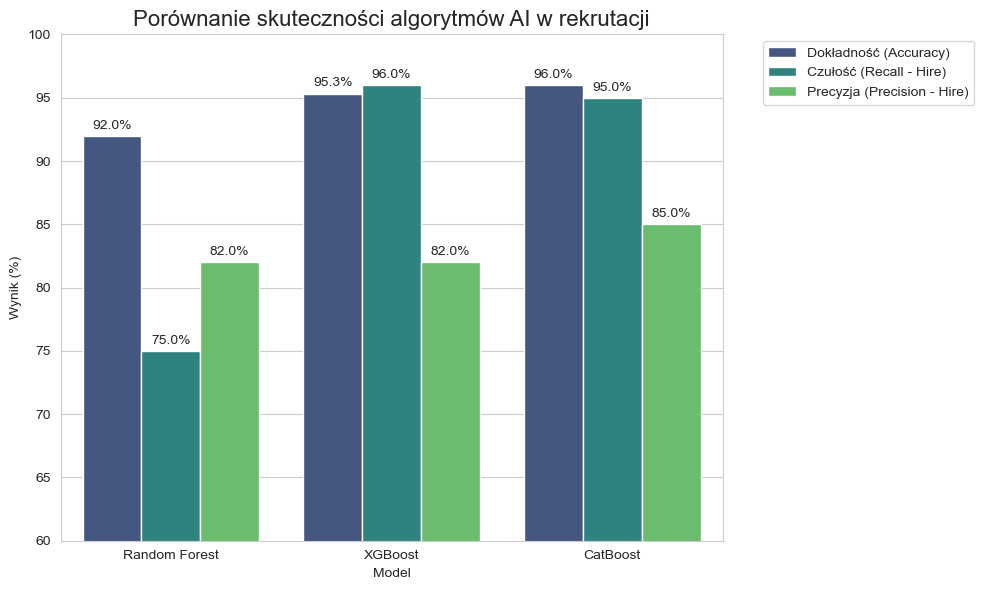

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Dane z Twoich testów
results_data = {
    'Model': ['Random Forest', 'XGBoost', 'CatBoost'],
    'Dokładność (Accuracy)': [92.00, 95.33, 96.00],
    'Czułość (Recall - Hire)': [75.00, 96.00, 95.00],
    'Precyzja (Precision - Hire)': [82.00, 82.00, 85.00]
}

df_results = pd.DataFrame(results_data)

# Konwersja tabeli na format "długi" dla wykresu
df_melted = df_results.melt(id_vars="Model", var_name="Metryka", value_name="Wynik (%)")

# Rysowanie wykresu
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
chart = sns.barplot(x="Model", y="Wynik (%)", hue="Metryka", data=df_melted, palette="viridis")

# Dodanie wartości nad słupkami
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f%%', padding=3)

plt.title("Porównanie skuteczności algorytmów AI w rekrutacji", fontsize=16)
plt.ylim(60, 100) # Skupiamy się na górnej części skali
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('porownanie_modeli.png')
plt.show()

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
import numpy as np

# Ustawienie stylu wykresów
sns.set_style("whitegrid")

# --- 1. Przygotowanie Danych i Modelu ---
try:
    df = pd.read_csv('data_after_filter.csv')
    
    # Usuwanie duplikatów i przygotowanie X, y
    df = df.loc[:, ~df.columns.duplicated()]
    X = df.drop(['Resume_ID', 'Recruiter Decision'], axis=1, errors='ignore')
    y = df['Recruiter Decision']

    # Podział (taki sam jak wcześniej)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Trening CatBoost (szybki)
    model = CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=6, 
        auto_class_weights='Balanced', verbose=0, random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predykcje
    y_pred = model.predict(X_test)

    print("Model gotowy. Generuję wykresy...")

    # --- WYKRES 1: Macierz Pomyłek (Confusion Matrix) ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Odrzucony', 'Zaproszony'], 
                yticklabels=['Odrzucony', 'Zaproszony'])
    plt.title('Macierz Pomyłek (Confusion Matrix) - CatBoost', fontsize=14)
    plt.ylabel('Prawdziwa Decyzja')
    plt.xlabel('Przewidywanie Modelu')
    plt.savefig('chart_confusion_matrix.png')
    plt.close()
    print("- Wygenerowano: chart_confusion_matrix.png")

    # --- WYKRES 2: Ważność Cech (Feature Importance) ---
    plt.figure(figsize=(10, 8))
    feat_importances = pd.Series(model.get_feature_importance(), index=X.columns)
    # Bierzemy top 10 cech
    feat_importances.nlargest(10).sort_values().plot(kind='barh', color='#4c72b0')
    plt.title('Top 10 Cech wpływających na zatrudnienie (wg CatBoost)', fontsize=14)
    plt.xlabel('Waga (Importance)')
    plt.savefig('chart_feature_importance.png')
    plt.close()
    print("- Wygenerowano: chart_feature_importance.png")

    # --- WYKRES 3: Wykształcenie a Decyzja (Education vs Hired) ---
    # Ponieważ dane są zakodowane liczbowo, zrobimy mapowanie dla czytelności (zakładając standardowe kodowanie)
    # Nawet jeśli etykiety 0,1,2,3 nie są opisane, zobaczymy różnice w proporcjach
    plt.figure(figsize=(10, 6))
    # Tworzymy tymczasową ramkę do wykresu
    plot_df = df.copy()
    plot_df['Decyzja'] = plot_df['Recruiter Decision'].map({0: 'Odrzucony', 1: 'Zaproszony'})
    
    sns.countplot(data=plot_df, x='Education', hue='Decyzja', palette='viridis')
    plt.title('Decyzje Rekrutera w zależności od poziomu edukacji', fontsize=14)
    plt.xlabel('Poziom Edukacji (Zakodowany)')
    plt.ylabel('Liczba Kandydatów')
    plt.legend(title='Decyzja')
    plt.savefig('chart_education_vs_hire.png')
    plt.close()
    print("- Wygenerowano: chart_education_vs_hire.png")

    # --- WYKRES 4: Doświadczenie (Histogram/KDE) ---
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=plot_df, x='Experience (Years)', hue='Decyzja', fill=True, palette='crest', alpha=0.5)
    plt.title('Rozkład lat doświadczenia: Zatrudnieni vs Odrzuceni', fontsize=14)
    plt.xlabel('Lata Doświadczenia')
    plt.savefig('chart_experience_kde.png')
    plt.close()
    print("- Wygenerowano: chart_experience_kde.png")

    print("\nGotowe! Wszystkie 4 wykresy zostały zapisane.")

except Exception as e:
    print(f"Wystąpił błąd: {e}")

Model gotowy. Generuję wykresy...
- Wygenerowano: chart_confusion_matrix.png
- Wygenerowano: chart_feature_importance.png
- Wygenerowano: chart_education_vs_hire.png
- Wygenerowano: chart_experience_kde.png

Gotowe! Wszystkie 4 wykresy zostały zapisane.


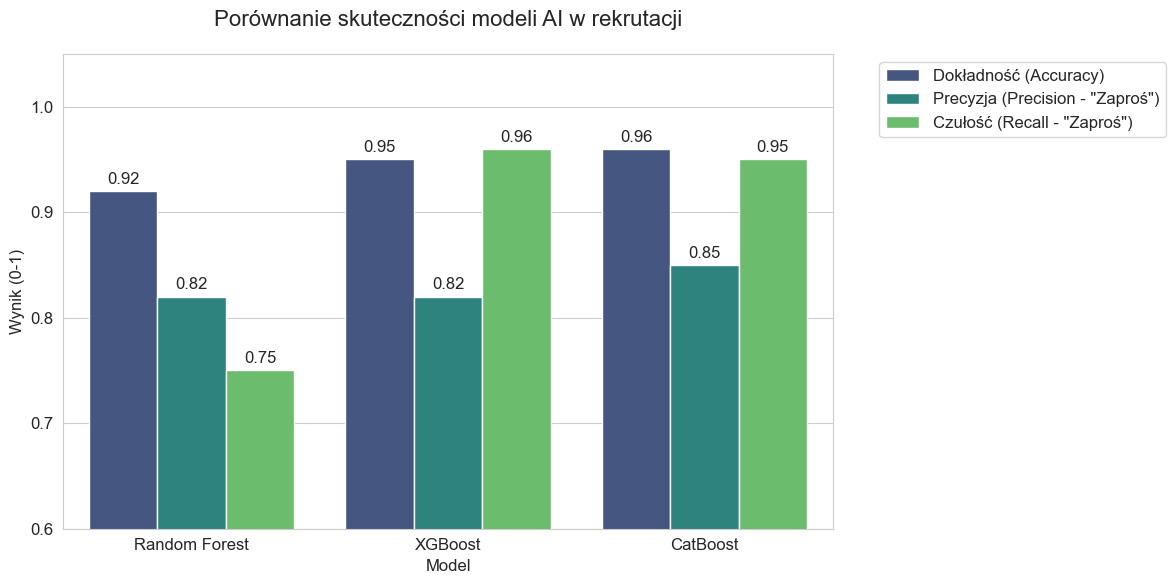

/var/folders/fr/xf8zmfr90fsfv_zpmb43xwb40000gn/T/ipykernel_75182/2679237084.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  recall_chart = sns.barplot(x="Model", y="Czułość (Recall - \"Zaproś\")", data=df, palette=colors)


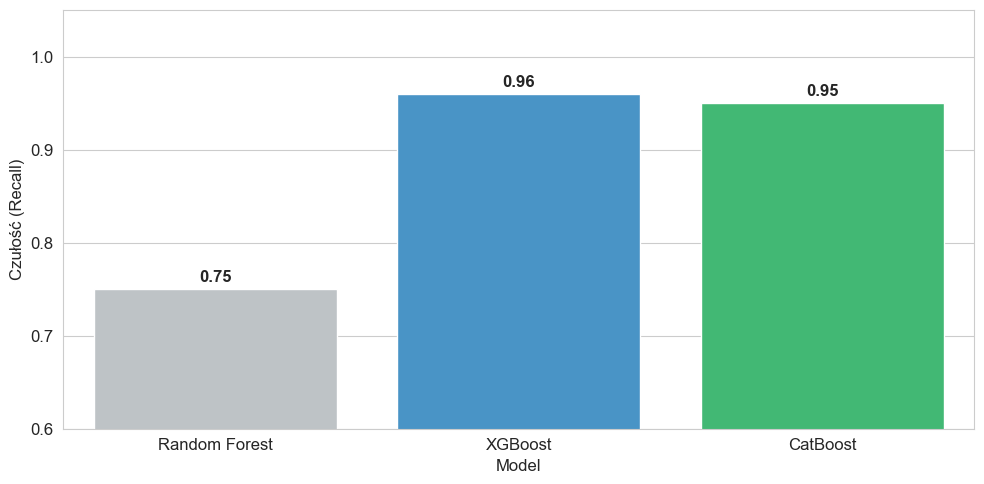

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Dane z Twoich wyników
data = {
    'Model': ['Random Forest', 'XGBoost', 'CatBoost'],
    'Dokładność (Accuracy)': [0.92, 0.95, 0.96],
    'Precyzja (Precision - "Zaproś")': [0.82, 0.82, 0.85],
    'Czułość (Recall - "Zaproś")': [0.75, 0.96, 0.95]
}

df = pd.DataFrame(data)

# Przekształcenie danych do formatu "długiego" dla łatwiejszego wykresowania w Seaborn
df_melted = df.melt(id_vars="Model", var_name="Metryka", value_name="Wartość")

# Ustawienia stylu
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# --- WYKRES 1: PORÓWNANIE OGÓLNE ---
plt.figure(figsize=(12, 6))
chart = sns.barplot(x="Model", y="Wartość", hue="Metryka", data=df_melted, palette="viridis")

# Dodanie etykiet z wartościami
for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3)

plt.title("Porównanie skuteczności modeli AI w rekrutacji", fontsize=16, pad=20)
plt.ylim(0.6, 1.05) # Skalowanie osi Y, żeby lepiej widzieć różnice
plt.ylabel("Wynik (0-1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n" + "="*50 + "\n")

# --- WYKRES 2: SKUTECZNOŚĆ W WYŁAPYWANIU TALENTÓW (RECALL) ---
# To jest kluczowe dla rekrutera - ilu dobrych kandydatów tracimy?
plt.figure(figsize=(10, 5))
colors = ['#bdc3c7', '#3498db', '#2ecc71'] # Szary, Niebieski, Zielony (wyróżnienie zwycięzców)
recall_chart = sns.barplot(x="Model", y="Czułość (Recall - \"Zaproś\")", data=df, palette=colors)

for container in recall_chart.containers:
    recall_chart.bar_label(container, fmt='%.2f', padding=3, fontsize=12, fontweight='bold')

plt.ylabel("Czułość (Recall)")
plt.ylim(0.6, 1.05)
plt.tight_layout()
plt.show()